In [77]:
import sys

sys.path.append('../')
from tools.img import dwt_2d_3c, idwt_2d_3c, dct_2d_3c_full_scale
import pywt
import PIL.Image
import numpy as np
from matplotlib import pyplot as plt
from torchvision.transforms.transforms import Compose, ToTensor, Resize
import matplotlib.pyplot as plt
from tools.img import tensor2ndarray, ndarray2tensor, rgb_to_yuv, yuv_to_rgb

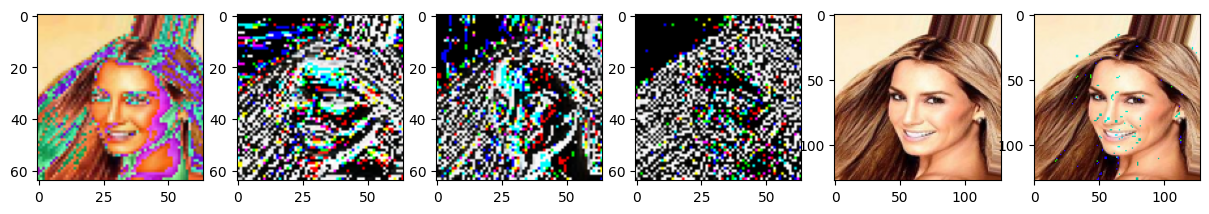

In [78]:
img = PIL.Image.open('/home/chengyiqiu/code/INBA/resource/example/000001.jpg')
scale = 128
img = img.resize((scale, scale))
x_0 = np.array(img)

coeff =  pywt.wavedec2(x_0, wavelet='haar', level=1, axes=(0, 1))
LL, (LH, HL, HH) = coeff
LL_yuv = np.stack(rgb_to_yuv(LL[:,:,0], LL[:,:,1], LL[:,:,2]), axis=-1)
ch_list = [1, 2]
window_size = 8
trigger_size = 4
for ch in ch_list:
    for i in range(0, LL_yuv.shape[0], window_size):
        for j in range(0, LL_yuv.shape[1], window_size):
            tmp = LL_yuv[i:i+window_size, j:j+window_size, ch]
            tmp_fft = np.fft.fft2(tmp, axes=(0, 1))
            amp, pha = np.abs(tmp_fft), np.angle(tmp_fft)
            pha[-1-trigger_size:-1, -1-trigger_size:-1] = 0
            tmp_fft = amp * np.exp(1j * pha)
            tmp = np.fft.ifft2(tmp_fft, axes=(0, 1))
            tmp = tmp.real
            LL_yuv[i:i+window_size, j:j+window_size, ch] = tmp
LL_poison = np.stack(yuv_to_rgb(LL_yuv[:,:,0], LL_yuv[:,:,1], LL_yuv[:,:,2]), axis=-1)
coeff = LL_poison, (LH, HL, HH)

x_c = pywt.waverec2(coeff, wavelet='haar', axes=(0, 1))

_, ax = plt.subplots(1, 6, figsize=(15, 5))
ax[0].imshow(LL.astype(np.uint8))
ax[1].imshow(LH.astype(np.uint8))
ax[2].imshow(HL.astype(np.uint8))
ax[3].imshow(HH.astype(np.uint8))
ax[4].imshow(x_0)
ax[5].imshow(x_c.astype(np.uint8))

plt.show()